## M04_1_addressee_classification_NH
A script that attempts the classification of the nominal 'addressee' variable for using a range of algorithms implemented using scikit learn and ~~the SMaPP text classifier~~ pipeline. Before this, I generated addressee classifications for all tweets using the tweet-text-filtering method (see script M03.R). So, beyond generating the classifications in this script, I will also compare them to the ones obtained through filtering. 

NL, 21/07/20


See also: M04_2, M04_3 --> both are also jupyter notebooks that execute the same code as here

In [57]:
import matplotlib.pyplot as plt
import random
import joblib

from smapp_text_classifier.data import DataSet
from smapp_text_classifier.models import TextClassifier
from smapp_text_classifier.plot import plot_learning_curve

import sys
import logging
import json
import sklearn

import numpy as np
import pandas as pd

from pprint import pprint

In [58]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
set(stopwords.words('english'))

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

#### Logging

In [59]:
logging.basicConfig(format='%(asctime)s - %(name)s - %(levelname)s - %(message)s', 
                    level=logging.INFO)
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
logging.getLogger("gensim").setLevel(logging.ERROR)
np.random.seed(989898)

### FUNCTIONS

### DATA IN

In [223]:
LABELLED_TWEETS = "/Users/nikloynes/Desktop/SENTIMENT/data/labelled_tweets/fmtd_with_metadata/"
UNLABELLED_TWEETS = "/Users/nikloynes/Desktop/SENTIMENT/data/located_users_tweets/with_mention_dummies/"
DATA_OUT = "/Users/nikloynes/Desktop/SENTIMENT/data/classifications/"

In [62]:
nh_df = pd.read_csv(LABELLED_TWEETS + 'new_hampshire.csv',  dtype = {'id' : 'str'})

In [176]:
nh_unlabelled_df = pd.read_json(UNLABELLED_TWEETS + 'new_hampshire.json', dtype = {'id' : 'str'}, lines=True)

In [64]:
nh_df

,id,text,bernie_score,hillary_score,addressee,timestamp,user_id,municipality,admin,county,ideology_bin,n_tweets,n_hillary,n_bernie,pop_norm,pop_quantiles
0,695344964755017728,Donald Trump and Bernie Sanders win the New Ha...,1.0,NaN,Bernie Sanders,2016-02-04 15:35:33,81126182,Durham,New Hampshire,United States,moderate,1,0,1,0.842397,4.0
1,696840745370529792,Hillary Clinton mulls a campaign staff shake-u...,NaN,-1.0,Hillary Clinton,2016-02-08 18:39:15,29599480,Concord,New Hampshire,United States,conservative,28,21,12,3.465415,4.0
2,694249917829750784,RT @jhutch1992: Let's be clear. This campaign ...,3.0,NaN,Bernie Sanders,2016-02-01 15:04:13,400255860,Concord,New Hampshire,United States,moderate,1,0,1,3.465415,4.0
3,696497445996359680,RT @MeninistTweet: Rt for puppy monkey baby\n\...,NaN,-2.0,Hillary Clinton,2016-02-07 19:55:06,3046904705,Newmarket,New Hampshire,United States,liberal,1,1,0,0.309324,4.0
4,696823971052920832,My predictions for #NH #FITN tomorrow: @Bernie...,0.0,NaN,Bernie Sanders,2016-02-08 17:32:35,28696353,Concord,New Hampshire,United States,liberal,1,0,1,3.465415,4.0
5,696084254535581696,RT @billyeichner: .@BernieSanders R u in the B...,0.0,NaN,Bernie Sanders,2016-02-06 16:33:13,2380466915,Temple,New Hampshire,United States,NaN,1,0,1,-0.398387,2.0
6,694603988491210752,"""Hell yeah more like Hill yeah!"" @johnbfortesc...",NaN,3.0,Hillary Clinton,2016-02-02 14:31:10,320343568,Hampton,New Hampshire,United States,moderate,2,1,1,0.916440,4.0
7,696899637219708928,RT @peterdaou: The massive trolling operation ...,NaN,3.0,Hillary Clinton,2016-02-08 22:33:15,99775711,Concord,New Hampshire,United States,liberal,43,37,18,3.465415,4.0
8,695459064910901248,RT @PolitiFact: Bernie Sanders says six bank c...,1.0,NaN,Bernie Sanders,2016-02-04 23:08:56,15013503,Concord,New Hampshire,United States,NaN,10,2,9,3.465415,4.0
9,696400615065448448,SNL Sends Up Larry David and Bernie Sanders wi...,2.0,NaN,Bernie Sanders,2016-02-07 13:30:19,154274811,Manchester,New Hampshire,United States,liberal,2,0,2,9.717016,4.0


In [70]:
from io import StringIO
col = ['id', 'addressee', 'text']
nh_df = nh_df[col]
nh_df = nh_df[pd.notnull(nh_df['text'])]
nh_df.columns = ['id', 'addressee', 'text']
nh_df['category_id'] = nh_df['addressee'].factorize()[0]
category_id_nh_df = nh_df[['addressee', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_nh_df.values)
id_to_category = dict(category_id_nh_df[['category_id', 'addressee']].values)
nh_df.head()

,id,addressee,text,category_id
0,695344964755017728,Bernie Sanders,Donald Trump and Bernie Sanders win the New Ha...,0
1,696840745370529792,Hillary Clinton,Hillary Clinton mulls a campaign staff shake-u...,1
2,694249917829750784,Bernie Sanders,RT @jhutch1992: Let's be clear. This campaign ...,0
3,696497445996359680,Hillary Clinton,RT @MeninistTweet: Rt for puppy monkey baby\n\...,1
4,696823971052920832,Bernie Sanders,My predictions for #NH #FITN tomorrow: @Bernie...,0


In [91]:
print(nh_df.text[0])

Donald Trump and Bernie Sanders win the New Hampshire Primary, well that what New Hampshire kids say!  On Tuesday... https://t.co/rnNQzMmSlr


In [74]:
nh_df.category_id.unique()

array([0, 1, 2, 3])

2020-07-22 20:36:32,104 - matplotlib.axes._base - DEBUG - update_title_pos
2020-07-22 20:36:32,119 - matplotlib.font_manager - DEBUG - findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.
2020-07-22 20:36:32,158 - matplotlib.axes._base - DEBUG - update_title_pos
2020-07-22 20:36:32,181 - matplotlib.axes._base - DEBUG - update_title_pos
2020-07-22 20:36:32,192 - matplotlib.axes._base - DEBUG - update_title_pos


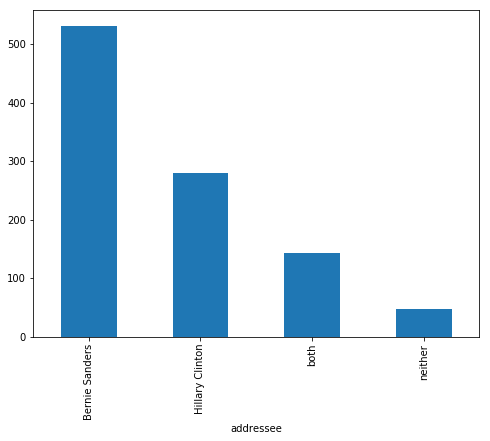

In [71]:
fig = plt.figure(figsize=(8,6))
nh_df.groupby('addressee').text.count().plot.bar(ylim=0)
plt.show()

# classes are unbalanced!!!

#### Upsampling all response categories

As shown in the bar plot above, the 4 classes (Bernie, Hillary, both, neither) are unbalanced in the training data. While there is no guarantee that this is the best thing to do in such a case, it makes sense to create an upsampled dataset in which all response categories are equally prevalent.

In [76]:
train_zero = nh_df[nh_df.category_id==0]
train_one = nh_df[nh_df.category_id==1]
train_two = nh_df[nh_df.category_id==2]
train_three = nh_df[nh_df.category_id==3]

train_one_upsampled = sklearn.utils.resample(train_one,
                               replace=True, 
                               n_samples=len(train_zero),
                               random_state=123)

train_two_upsampled = sklearn.utils.resample(train_two,
                               replace=True, 
                               n_samples=len(train_zero),
                               random_state=123)

train_three_upsampled = sklearn.utils.resample(train_three,
                                 replace=True, 
                                 n_samples=len(train_zero),
                                 random_state=123)

nh_upsampled_df = pd.concat([train_zero, train_one_upsampled, train_two_upsampled, train_three_upsampled])
nh_upsampled_df['category_id'].value_counts()

3    531
1    531
2    531
0    531
Name: category_id, dtype: int64

#### Vectorising the data to tf-idf

Sklearn can't learn the relationship between texts and labels directly -- first, the text needs to be transformed to a numerical representation. The below cell does this using the tf-ids method (term frequency, inverse document frequency). This method is likely superior to the simple 'bag of words' (term frequency) model, as it not only takes into account the frequency of a given term within a document (tweet), but also how it is relatively differenlty likely to appear in a given document. This helps the classifier decide on the correct class for a given tweet.

In [211]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, 
                        min_df=5, 
                        norm='l2', 
                        encoding='latin-1', 
                        ngram_range=(1, 2), 
                        stop_words='english')

features = tfidf.fit_transform(nh_upsampled_df.text)
labels = nh_upsampled_df.category_id
features.shape

(2124, 1935)

#### Exploratory metrics: Most correlated n-grams / training labels

In [86]:
from sklearn.feature_selection import chi2
N = 2

for addressee, category_id in sorted(category_to_id.items()):
    features_chi2 = chi2(features, labels == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}':".format(addressee))
    print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
    print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'Bernie Sanders':
  . Most correlated unigrams:
. sanders
. bernie
  . Most correlated bigrams:
. hillary clinton
. bernie sanders
# 'Hillary Clinton':
  . Most correlated unigrams:
. clinton
. hillary
  . Most correlated bigrams:
. rt hillaryclinton
. hillary clinton
# 'both':
  . Most correlated unigrams:
. nhdems
. thedemocrats
  . Most correlated bigrams:
. hillaryclinton berniesanders
. berniesanders hillaryclinton
# 'neither':
  . Most correlated unigrams:
. cc
. kgrohh
  . Most correlated bigrams:
. cc kgrohh
. hillaryclinton cc


#### Instantiating the data for training

In this step, the training data gets transformed into the right format and split, so that multiple algorithms can be applied to learning the connection between features and labels. For this purpose, I test:

- Naive Bayes
- SVM
- Random Forest
- Logistic Regression

In [88]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(nh_upsampled_df['text'], nh_upsampled_df['addressee'], random_state = 0)

count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed

2020-07-22 22:44:08,751 - matplotlib.axes._base - DEBUG - update_title_pos
2020-07-22 22:44:08,775 - matplotlib.axes._base - DEBUG - update_title_pos
2020-07-22 22:44:08,792 - matplotlib.axes._base - DEBUG - update_title_pos


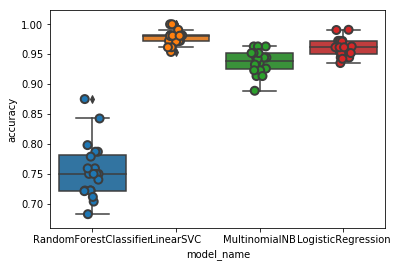

In [111]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]

CV = 20

cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
        cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
        
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [112]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.976941
LogisticRegression        0.960452
MultinomialNB             0.936859
RandomForestClassifier    0.755662
Name: accuracy, dtype: float64

#### It appears that SVM is by far the best model for this task. Now, to tune the hyper-parameters.

2020-07-23 18:04:54,122 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.MaxNLocator object at 0x1a3223a1d0>
2020-07-23 18:04:54,125 - matplotlib.colorbar - DEBUG - Using auto colorbar locator on colorbar
2020-07-23 18:04:54,126 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.MaxNLocator object at 0x1a3223a1d0>
2020-07-23 18:04:54,127 - matplotlib.colorbar - DEBUG - Setting pcolormesh
2020-07-23 18:04:54,150 - matplotlib.axes._base - DEBUG - update_title_pos
2020-07-23 18:04:54,257 - matplotlib.axes._base - DEBUG - update_title_pos
2020-07-23 18:04:54,334 - matplotlib.axes._base - DEBUG - update_title_pos
2020-07-23 18:04:54,377 - matplotlib.axes._base - DEBUG - update_title_pos
2020-07-23 18:04:54,415 - matplotlib.axes._base - DEBUG - update_title_pos
2020-07-23 18:04:54,432 - matplotlib.axes._base - DEBUG - update_title_pos
2020-07-23 18:04:54,464 - matplotlib.axes._base - DEBUG - update_title_pos
2020-07-23 18:04:54,480 - matplotlib.axes._base - DEBUG - update

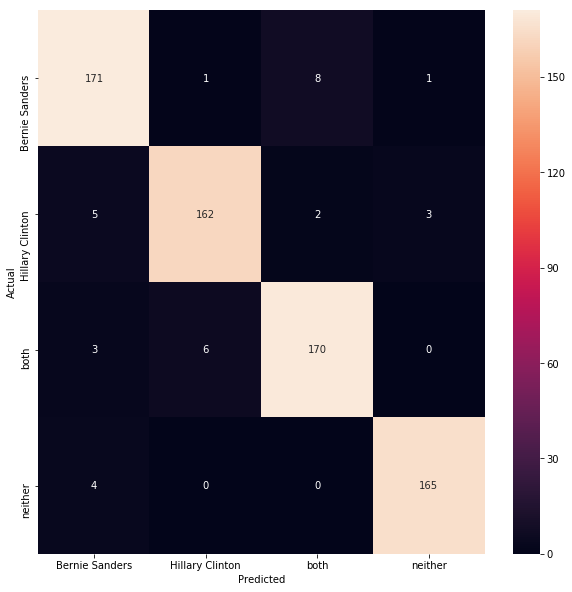

In [225]:
from sklearn.svm import SVC

# new model that incorporates probabilities. this might help decide which label to choose when 
# filtering-derived and ML-derived classifications are different.
model = SVC(kernel='linear', probability=True, random_state=0)
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, nh_upsampled_df.index, test_size=0.33, random_state=0)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_nh_df.addressee.values, yticklabels=category_id_nh_df.addressee.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

The 'get_params()' method on the classifier object tells us which hyper-parameters were selected for this model. This allows us to tune the parameters using k-fold cross-validation. This is implemented using the 'GridSearchCV' method, using different tuning parameters defined in 'param_grid' 

In [226]:
model.get_params()

{'C': 1.0,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'auto_deprecated',
 'kernel': 'linear',
 'max_iter': -1,
 'probability': True,
 'random_state': 0,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [227]:
param_grid = {'C': [1, 10, 50, 100, 200, 500, 1000, 10000], 'max_iter' : [1000, 10000, 100000]}

In [228]:
from sklearn.model_selection import GridSearchCV
clf = GridSearchCV(cv=10,estimator=model, param_grid=param_grid)
clf.fit(features, labels)

/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.

/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.

/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=True, random_state=0,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [1, 10, 50, 100, 200, 500, 1000, 10000], 'max_iter': [1000, 10000, 100000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

### The most accurate/predictive model is chosen using the 'best_estimator' attribute on the cross-validation object.

In [229]:
final_model = clf.best_estimator_

final_model.fit(X_train, y_train)
final_model_preds = final_model.predict(X_test)

In [230]:
from sklearn import metrics
print(metrics.classification_report(y_test, final_model_preds, target_names=nh_df['addressee'].unique()))

                 precision    recall  f1-score   support

 Bernie Sanders       0.96      0.95      0.95       181
Hillary Clinton       0.97      0.97      0.97       172
           both       0.95      0.95      0.95       179
        neither       0.98      0.98      0.98       169

      micro avg       0.96      0.96      0.96       701
      macro avg       0.96      0.96      0.96       701
   weighted avg       0.96      0.96      0.96       701



## Now to apply the model on previously unseen data!

The previously unseen data is the 'nh_unlabelled_df' data frame. It needs to be slightly transformed first, including removal of columns that aren't relevant for this task. Also, the 'addressee' variable is transformed from the 'bernie_mention' and 'hillary_mention' variables, as these are dummies themselves, and not a 4-level categorical variable like the one we are looking to predict. The 'bernie_mention' and 'hillary_mention' variables come from the tweet text filtering approach taken in M_03.R.

In [231]:
col = ['id_str', 'text', 'bernie_mention', 'hillary_mention']
nh_unlabelled_df = nh_unlabelled_df[col]

In [232]:
nh_unlabelled_df['addressee'] = 'neither'
nh_unlabelled_df.loc[(nh_unlabelled_df.bernie_mention==True) & (nh_unlabelled_df.hillary_mention==True), 'addressee'] = 'both'
nh_unlabelled_df.loc[(nh_unlabelled_df.bernie_mention==True) & (nh_unlabelled_df.hillary_mention==False), 'addressee'] = 'Bernie Sanders'
nh_unlabelled_df.loc[(nh_unlabelled_df.bernie_mention==False) & (nh_unlabelled_df.hillary_mention==True), 'addressee'] = 'Hillary Clinton'
nh_unlabelled_df = nh_unlabelled_df[pd.notnull(nh_unlabelled_df['text'])]

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [233]:
# what does the naive mention classification say about distribution of mentions by candidate?
# let' see how it compares to the classified values.
nh_unlabelled_df.addressee.value_counts()

Bernie Sanders     8967
Hillary Clinton    5810
both               3305
Name: addressee, dtype: int64

In [234]:
features_unseen = tfidf.transform(nh_unlabelled_df.text)
features_unseen.shape

(18082, 1935)

In [235]:
# make prediction on new data

preds_unseen_data = final_model.predict(features_unseen)
probs_unseen_data = final_model.predict_proba(features_unseen)

In [236]:
class_probabilites_df = pd.DataFrame(data=probs_unseen_data)
class_probabilites_df.columns = ['class_0', 'class_1', 'class_2', 'class_3']
class_probabilites_df = class_probabilites_df.round(decimals=3)

In [237]:
nh_unlabelled_df['preds_addressee'] = preds_unseen_data 
nh_unlabelled_df = pd.concat([nh_unlabelled_df, class_probabilites_df], axis=1)

In [238]:
nh_unlabelled_df

,id_str,text,bernie_mention,hillary_mention,addressee,preds_addressee,class_0,class_1,class_2,class_3
0,693269454881447936,@NHDems @iowademocrats @scdp #nhpolitics #iaca...,False,True,Hillary Clinton,1,0.000,0.996,0.004,0.000
1,692950898134368256,@NHDems @SCdems #nhpolitics #iapolitics #iacau...,True,True,both,2,0.005,0.023,0.972,0.000
2,692953880255152128,@NHDems @SCdems #nhpolitics #iapolitics #iacau...,True,True,both,2,0.005,0.023,0.972,0.000
3,693064737748340736,The bros who love Bernie Sanders have become a...,True,True,both,0,0.825,0.109,0.044,0.022
4,693261130333057024,RT @ABCLiz: Bill Clinton on what Hillary Clint...,False,True,Hillary Clinton,1,0.000,1.000,0.000,0.000
5,693036457217429504,RT @JazzShaw: Wow. Morning Joe crew actually d...,False,True,Hillary Clinton,1,0.003,0.964,0.017,0.016
6,693244905079095296,RT @cnnbrk: State Department says it won't rel...,False,True,Hillary Clinton,1,0.000,0.995,0.005,0.000
7,692998848143347712,@HillaryClinton,False,True,Hillary Clinton,1,0.000,0.999,0.001,0.000
8,693002209722830848,RT @Bernie_Sanders_: Robert Reich: I’ve Known ...,True,True,both,0,0.809,0.014,0.175,0.003
9,692952350873538560,RT @GuerrillaDems: #HillaryClinton 's attack d...,False,True,Hillary Clinton,1,0.000,0.990,0.009,0.000


In [239]:
# writing out nh_unlabelled_df to a csv file
nh_unlabelled_df.to_csv(DATA_OUT+'nh_addressee_classified.csv', index=False)

In [242]:
nh_unlabelled_df.preds_addressee.value_counts()

0    9339
1    6104
2    2510
3     129
Name: preds_addressee, dtype: int64

In [241]:
nh_unlabelled_df.addressee.value_counts()

Bernie Sanders     8967
Hillary Clinton    5810
both               3305
Name: addressee, dtype: int64

# BELOW ARE INITIAL ATTEMPTS WITH VARIOUS TUTORIALS, ALSO A SEMI-SUCCESSFUL SMAPP PIPELINE IMPLEMENTATION

In [52]:
tokenizer = nltk.TweetTokenizer()

In [53]:
dataset = DataSet(input_=nh_df, name='new_hampshire',
                  field_mapping={'label': 'addressee', 'text': 'text'})

In [54]:
algorithms = ['random_forest', 'elasticnet', 'svm', 'naive_bayes']
feature_sets = ['embeddings', 'char_ngrams', 'word_ngrams']

In [55]:
for algorithm in algorithms:
    for feature_set in feature_sets:
        print(f'Fitting {algorithm} with {feature_set}')
        
        clf = TextClassifier(
            dataset=dataset, 
            algorithm=algorithm, 
            feature_set=feature_set, 
            max_n_features=10000, 
            embedding_model_name='glove-twitter-100'
        )

        CV = sklearn.model_selection.RandomizedSearchCV(
            clf.pipeline,
            param_distributions=clf.params,
            n_iter=10, 
            cv=3, 
            n_jobs=8,
            scoring='accuracy', 
            iid=False
        )
        
        X = dataset.get_texts('train')
        y = dataset.get_labels('train')
        CV = CV.fit(X, y)
        print(CV.best_score_)
        
        y_valid = dataset.get_labels('test')
        X_valid = dataset.get_texts('test')
        y_pred = CV.predict(X_valid)
        score = round(sklearn.metrics.accuracy_score(y_true=y_valid, y_pred=y_pred), 3)
        print(f'Best score for {algorithm} with {feature_set} on test set: {score}')
        
        best_t_params = CV.best_estimator_.get_params()

2020-07-22 19:27:34,221 - root - DEBUG - Pre-computing feature_cache/new_hampshire_glove-twitter-100_mean.pkl
2020-07-22 19:27:34,222 - root - DEBUG - Transforming from cache
2020-07-22 19:27:34,223 - root - DEBUG - Cache not found
2020-07-22 19:27:34,224 - root - DEBUG - Transforming from scratch
2020-07-22 19:27:34,225 - root - DEBUG - Loading embedding model


Fitting random_forest with embeddings
[==================================================] 100.0% 387.1/387.1MB downloaded


2020-07-22 19:28:28,482 - smart_open.smart_open_lib - DEBUG - {'uri': '/Users/nikloynes/gensim-data/glove-twitter-100/glove-twitter-100.gz', 'mode': 'rb', 'buffering': -1, 'encoding': None, 'errors': None, 'newline': None, 'closefd': True, 'opener': None, 'ignore_ext': False, 'transport_params': None}
2020-07-22 19:30:26,364 - root - DEBUG - _load_embedding_model took 172.14s
2020-07-22 19:30:26,672 - root - DEBUG - fit_transform took 172.45s
2020-07-22 19:30:26,673 - root - DEBUG - Pre-computing feature_cache/new_hampshire_glove-twitter-100_max.pkl
2020-07-22 19:30:26,674 - root - DEBUG - Transforming from cache
2020-07-22 19:30:26,675 - root - DEBUG - Cache not found
2020-07-22 19:30:26,675 - root - DEBUG - Transforming from scratch
2020-07-22 19:30:26,676 - root - DEBUG - Loading embedding model
2020-07-22 19:30:26,758 - smart_open.smart_open_lib - DEBUG - {'uri': '/Users/nikloynes/gensim-data/glove-twitter-100/glove-twitter-100.gz', 'mode': 'rb', 'buffering': -1, 'encoding': None, 

0.5799741862536467
Best score for random_forest with embeddings on test set: 0.568
Fitting random_forest with char_ngrams


2020-07-22 19:32:42,782 - root - DEBUG - fit_transform took 0.43s
2020-07-22 19:32:42,784 - root - DEBUG - Pre-computing feature_cache/new_hampshire_char_wb_(3, 4).joblib
2020-07-22 19:32:42,784 - root - DEBUG - Transforming from cache
2020-07-22 19:32:42,785 - root - DEBUG - Cache not found
2020-07-22 19:32:42,786 - root - DEBUG - Transforming from scratch
2020-07-22 19:32:43,369 - root - DEBUG - fit_transform took 0.58s
2020-07-22 19:32:43,370 - root - DEBUG - Pre-computing feature_cache/new_hampshire_char_wb_(3, 5).joblib
2020-07-22 19:32:43,370 - root - DEBUG - Transforming from cache
2020-07-22 19:32:43,371 - root - DEBUG - Cache not found
2020-07-22 19:32:43,372 - root - DEBUG - Transforming from scratch
2020-07-22 19:32:44,134 - root - DEBUG - fit_transform took 0.76s
2020-07-22 19:32:51,388 - root - DEBUG - Transforming from cache
2020-07-22 19:32:51,614 - root - DEBUG - _load_from_cache took 0.23s
2020-07-22 19:32:51,615 - root - DEBUG - Checking if cache matches index docs
20

0.9173164583966678


2020-07-22 19:32:52,381 - root - DEBUG - _load_from_cache took 0.23s
2020-07-22 19:32:52,382 - root - DEBUG - Checking if cache matches index docs
2020-07-22 19:32:52,387 - root - DEBUG - transform took 0.23s
2020-07-22 19:32:52,469 - root - DEBUG - Pre-computing feature_cache/new_hampshire_word_(1, 1).joblib
2020-07-22 19:32:52,470 - root - DEBUG - Transforming from cache
2020-07-22 19:32:52,471 - root - DEBUG - Cache not found
2020-07-22 19:32:52,472 - root - DEBUG - Transforming from scratch
2020-07-22 19:32:52,618 - root - DEBUG - fit_transform took 0.15s
2020-07-22 19:32:52,619 - root - DEBUG - Pre-computing feature_cache/new_hampshire_word_(1, 2).joblib
2020-07-22 19:32:52,620 - root - DEBUG - Transforming from cache
2020-07-22 19:32:52,620 - root - DEBUG - Cache not found
2020-07-22 19:32:52,621 - root - DEBUG - Transforming from scratch


Best score for random_forest with char_ngrams on test set: 0.912
Fitting random_forest with word_ngrams


2020-07-22 19:32:52,966 - root - DEBUG - fit_transform took 0.35s
2020-07-22 19:32:52,966 - root - DEBUG - Pre-computing feature_cache/new_hampshire_word_(1, 3).joblib
2020-07-22 19:32:52,967 - root - DEBUG - Transforming from cache
2020-07-22 19:32:52,968 - root - DEBUG - Cache not found
2020-07-22 19:32:52,968 - root - DEBUG - Transforming from scratch
2020-07-22 19:32:53,409 - root - DEBUG - fit_transform took 0.44s
2020-07-22 19:33:02,137 - root - DEBUG - Transforming from cache
2020-07-22 19:33:02,272 - root - DEBUG - _load_from_cache took 0.13s
2020-07-22 19:33:02,273 - root - DEBUG - Checking if cache matches index docs
2020-07-22 19:33:02,278 - root - DEBUG - fit_transform took 0.14s
2020-07-22 19:33:03,857 - root - DEBUG - Transforming from cache
2020-07-22 19:33:03,981 - root - DEBUG - _load_from_cache took 0.12s
2020-07-22 19:33:03,982 - root - DEBUG - Checking if cache matches index docs
2020-07-22 19:33:03,987 - root - DEBUG - transform took 0.13s


0.8306488530483155
Best score for random_forest with word_ngrams on test set: 0.832
Fitting elasticnet with embeddings


2020-07-22 19:33:04,404 - root - DEBUG - Transforming from cache
2020-07-22 19:33:04,409 - root - DEBUG - _load_from_cache took 0.00s
2020-07-22 19:33:04,411 - root - DEBUG - Checking if cache matches index docs
2020-07-22 19:33:04,418 - root - DEBUG - fit_transform took 0.01s
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
2020-07-22 19:33:04,450 - root - DEBUG - Transforming from cache
2020-07-22 19:33:04,456 - root - DEBUG - _load_from_cache took 0.00s
2020-07-22 19:33:04,458 - root - DEBUG - Checking if cache matches index docs
2020-07-22 19:33:04,462 - root - DEBUG - transform took 0.01s


0.5306669866717867
Best score for elasticnet with embeddings on test set: 0.532
Fitting elasticnet with char_ngrams


2020-07-22 19:33:08,262 - root - DEBUG - Transforming from cache
2020-07-22 19:33:08,448 - root - DEBUG - _load_from_cache took 0.19s
2020-07-22 19:33:08,450 - root - DEBUG - Checking if cache matches index docs
2020-07-22 19:33:08,456 - root - DEBUG - fit_transform took 0.19s
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
2020-07-22 19:33:08,491 - root - DEBUG - Transforming from cache
2020-07-22 19:33:08,660 - root - DEBUG - _load_from_cache took 0.17s
2020-07-22 19:33:08,661 - root - DEBUG - Checking if cache matches index docs
2020-07-22 19:33:08,666 - root - DEBUG - transform took 0.18s


0.902649663727953
Best score for elasticnet with char_ngrams on test set: 0.868
Fitting elasticnet with word_ngrams


2020-07-22 19:33:11,392 - root - DEBUG - Transforming from cache
2020-07-22 19:33:11,513 - root - DEBUG - _load_from_cache took 0.12s
2020-07-22 19:33:11,515 - root - DEBUG - Checking if cache matches index docs
2020-07-22 19:33:11,519 - root - DEBUG - fit_transform took 0.13s
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
2020-07-22 19:33:11,528 - root - DEBUG - Transforming from cache
2020-07-22 19:33:11,663 - root - DEBUG - _load_from_cache took 0.13s
2020-07-22 19:33:11,664 - root - DEBUG - Checking if cache matches index docs
2020-07-22 19:33:11,669 - root - DEBUG - transform took 0.14s


0.8786494930585556
Best score for elasticnet with word_ngrams on test set: 0.864
Fitting svm with embeddings


2020-07-22 19:33:12,860 - root - DEBUG - Transforming from cache
2020-07-22 19:33:12,865 - root - DEBUG - _load_from_cache took 0.00s
2020-07-22 19:33:12,866 - root - DEBUG - Checking if cache matches index docs
2020-07-22 19:33:12,870 - root - DEBUG - fit_transform took 0.01s
2020-07-22 19:33:12,989 - root - DEBUG - Transforming from cache
2020-07-22 19:33:12,994 - root - DEBUG - _load_from_cache took 0.00s
2020-07-22 19:33:12,995 - root - DEBUG - Checking if cache matches index docs
2020-07-22 19:33:12,999 - root - DEBUG - transform took 0.01s


0.574619348576244
Best score for svm with embeddings on test set: 0.584
Fitting svm with char_ngrams


2020-07-22 19:33:20,704 - root - DEBUG - Transforming from cache
2020-07-22 19:33:20,822 - root - DEBUG - _load_from_cache took 0.12s
2020-07-22 19:33:20,823 - root - DEBUG - Checking if cache matches index docs
2020-07-22 19:33:20,829 - root - DEBUG - fit_transform took 0.12s
2020-07-22 19:33:21,119 - root - DEBUG - Transforming from cache
2020-07-22 19:33:21,233 - root - DEBUG - _load_from_cache took 0.11s
2020-07-22 19:33:21,234 - root - DEBUG - Checking if cache matches index docs
2020-07-22 19:33:21,238 - root - DEBUG - transform took 0.12s


0.899988351813629
Best score for svm with char_ngrams on test set: 0.872
Fitting svm with word_ngrams


2020-07-22 19:33:24,384 - root - DEBUG - Transforming from cache
2020-07-22 19:33:24,507 - root - DEBUG - _load_from_cache took 0.12s
2020-07-22 19:33:24,508 - root - DEBUG - Checking if cache matches index docs
2020-07-22 19:33:24,512 - root - DEBUG - fit_transform took 0.13s
2020-07-22 19:33:24,610 - root - DEBUG - Transforming from cache
2020-07-22 19:33:24,734 - root - DEBUG - _load_from_cache took 0.12s
2020-07-22 19:33:24,735 - root - DEBUG - Checking if cache matches index docs
2020-07-22 19:33:24,739 - root - DEBUG - transform took 0.13s


0.8733106769708315
Best score for svm with word_ngrams on test set: 0.872
Fitting naive_bayes with embeddings


2020-07-22 19:33:25,067 - root - DEBUG - Transforming from cache
2020-07-22 19:33:25,071 - root - DEBUG - _load_from_cache took 0.00s
2020-07-22 19:33:25,072 - root - DEBUG - Checking if cache matches index docs
2020-07-22 19:33:25,076 - root - DEBUG - fit_transform took 0.01s
2020-07-22 19:33:25,080 - root - DEBUG - Transforming from cache
2020-07-22 19:33:25,085 - root - DEBUG - _load_from_cache took 0.00s
2020-07-22 19:33:25,086 - root - DEBUG - Checking if cache matches index docs
2020-07-22 19:33:25,090 - root - DEBUG - transform took 0.01s


0.42136989925172136
Best score for naive_bayes with embeddings on test set: 0.42
Fitting naive_bayes with char_ngrams


TypeError: A sparse matrix was passed, but dense data is required. Use X.toarray() to convert to a dense numpy array.